<a href="https://colab.research.google.com/github/BOINISHIVANANDAM/FakeCurrencyDetectionSystem/blob/master/Fake_Note_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!git clone https://github.com/viram-jain/FakeCurrencyDetectionSystem.git

fatal: destination path 'FakeCurrencyDetectionSystem' already exists and is not an empty directory.


In [46]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.4.1)


In [56]:
#import all necessary modules
from tensorflow import keras
#from tensorflow.keras.preprocessing.image import image_dataset_from_directory
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout
from keras.models import Sequential
from keras_preprocessing.image import image_data_generator
from keras.models import Model
from keras.models import load_model
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
import numpy as np
import matplotlib.pyplot as plt


In [57]:
#define height and width of the image
height=300
width=300

#create a ResNet50 model instance without the top layer as we will add our own top layer
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(height,width,3))

In [59]:
#define directory containing training and validation data
train_dir="/content/FakeCurrencyDetectionSystem/Dataset/Training"
validation_dir="/content/FakeCurrencyDetectionSystem/Dataset/Validation"

#number of batches the data has to be divided into
batch_size=8

#create datagen and generator to load the data from training directory
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=90,horizontal_flip=True,vertical_flip=True)
train_generator=train_datagen.flow_from_directory(train_dir,target_size=(height,width),batch_size=batch_size)

#create datagen and generator to load the data from validation directory
validation_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=90,horizontal_flip=True,vertical_flip=True)
validation_generator=validation_datagen.flow_from_directory(validation_dir,target_size=(height,width),batch_size=batch_size)

Found 35 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


In [60]:
#our own model which will be added onto the ResNet50 model
def build_finetune_model(base_model,dropout,fc_layers,num_classes):
    for layer in base_model.layers:
        layer.trainable=False

    x=base_model.output
    x=Flatten()(x)
    for fc in fc_layers:
        x=Dense(fc,activation='relu')(x)
        x=Dropout(dropout)(x)
    
    predictions=Dense(num_classes,activation='softmax')(x)

    finetune_model=Model(inputs=base_model.input,outputs=predictions) 
    
    return finetune_model

class_list=['Real','Fake'] #the labels of our data
FC_Layers=[1024,1024]
dropout=0.5

finetune_model=build_finetune_model(base_model,dropout=dropout,fc_layers=FC_Layers,num_classes=len(class_list))

In [61]:
#define number of epochs(the number of times the model will be trained) and number of training images
num_epochs=2
num_train_images=35


In [62]:
#checkpoint in case anything goes wrong
checkpoint=ModelCheckpoint("Final_model.h5",monitor='val_acc',verbose=1,save_best_only=True,save_weights_only=False,mode='auto',period=1)
early=EarlyStopping(monitor='val_acc',min_delta=0,patience=40,verbose=1,mode="auto")

#compile the model before using
finetune_model.compile(loss="categorical_crossentropy",optimizer=optimizers.SGD(lr=0.000001,momentum=0.9),metrics=['accuracy'])

#train the model
finetune_model.fit_generator(generator=train_generator,steps_per_epoch=num_train_images//batch_size,epochs=num_epochs,validation_data=validation_generator,validation_steps=1,callbacks=[checkpoint,early])

#save the model
finetune_model.save_weights("Final_model.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
4/4 [==============================] - 16s 3s/step - loss: 2.1037 - accuracy: 0.5458 - val_loss: 0.9565 - val_accuracy: 0.5714
Epoch 2/2
4/4 [==============================] - 11s 3s/step - loss: 1.3383 - accuracy: 0.5282 - val_loss: 1.5200 - val_accuracy: 0.5714


Fake


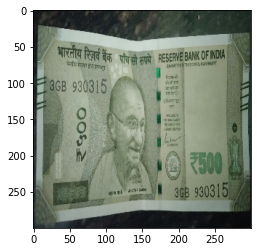

In [63]:
#testing the model
img=image.load_img("/content/FakeCurrencyDetectionSystem/Dataset/Testing/Real.jpg",target_size=(300,300)) #The path of the testing image,the pic taken from the phone should come here
img=np.asarray(img)
plt.imshow(img)
img=np.expand_dims(img,axis=0)
finetune_model.load_weights("Final_model.h5")

output=finetune_model.predict(img) #predicting the image using model created
if(output[0][0]>output[0][1]): #comparison
    print("Fake")
else:
    print("Real")

Fake


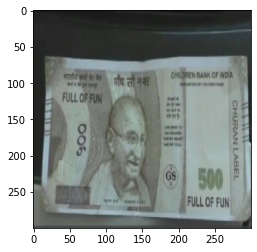

In [64]:
#testing the model
img=image.load_img("/content/FakeCurrencyDetectionSystem/Dataset/Testing/Fake.jpeg",target_size=(300,300)) #The path of the testing image,the pic taken from the phone should come here
img=np.asarray(img)
plt.imshow(img)
img=np.expand_dims(img,axis=0)
finetune_model.load_weights("Final_model.h5")

output=finetune_model.predict(img) #predicting the image using model created
if(output[0][0]>output[0][1]): #comparison
    print("Fake")
else:
    print("Real")